# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import datetime

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

from dataloader.load_regression_data_from_arbitrary_gp import RegressionDataGeneratorArbitraryGP

from model import ConditionalNeuralProcess

from utils.plot import plot_learning_curve
from utils.gaussian_processes.gp_model import plot_mean_with_std
from utils.gaussian_processes.plot_gp_utils import plot_preds_from_ds_test, plot_preds_from_single_example

from utils.plot import plot_from_arbitrary_gp_wrt_context_points
from utils.plot import plot_gp_vs_cnp_vs_lnp

2023-03-22 12:48:41.967748: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 12:48:43.105813: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-22 12:48:43.105837: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-22 12:48:43.227585: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-22 12:48:46.039044: W tensorflow/stream_executor/pla

# DataGenerator

In [2]:
KERNEL_LENGTH_SCALE = 0.4

data_generator = RegressionDataGeneratorArbitraryGP(
    iterations=25,
    batch_size=32,
    min_num_context=3,
    max_num_context=40,
    min_num_target=2,
    max_num_target=40,
    min_x_val_uniform=-2,
    max_x_val_uniform=2,
    kernel_length_scale=KERNEL_LENGTH_SCALE
)

2023-03-22 12:48:50.842243: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-22 12:48:50.843081: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-22 12:48:50.843128: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2023-03-22 12:48:50.849129: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


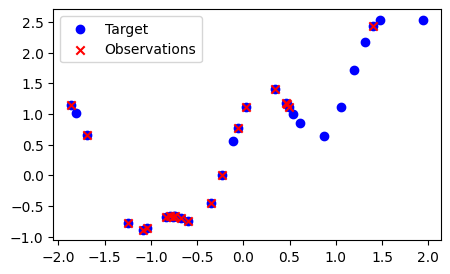

In [3]:
data_generator.plot_first_elt_of_random_batch(figsize=(5, 3));

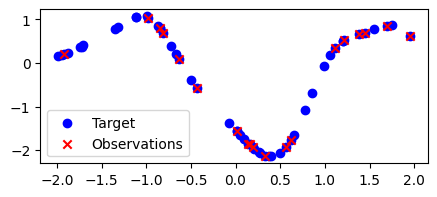

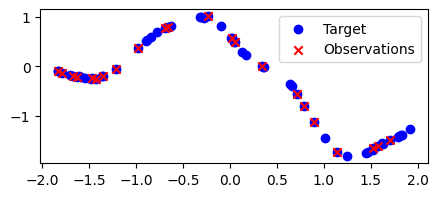

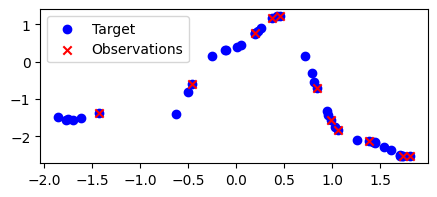

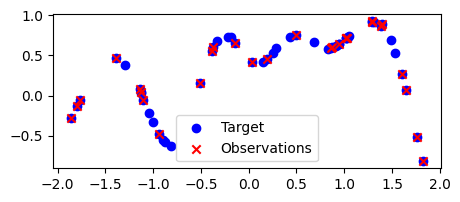

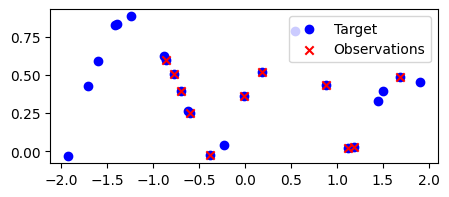

In [4]:
for (context_x, context_y, target_x), target_y in data_generator.train_ds.take(5):
    RegressionDataGeneratorArbitraryGP.plot_first_elt_of_batch(context_x, context_y, target_x, target_y,
                                                               figsize=(5, 2));

# Train CNP

In [5]:
encoder_dims = [500, 500, 500, 500]
decoder_dims = [500, 500, 500, 2]

def loss(target_y, pred_y):
    # Get the distribution
    mu, sigma = tf.split(pred_y, num_or_size_splits=2, axis=-1)
    dist = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
    return -dist.log_prob(target_y)

model = ConditionalNeuralProcess(encoder_dims, decoder_dims)
model.compile(loss=loss, optimizer='adam')

In [6]:
callbacks = []

log_dir = f'logs/cnp/regression/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=5)

callbacks.append(tensorboard_callback)

callbacks.append(
    tf.keras.callbacks.EarlyStopping(
        patience=25,
        monitor="val_loss",
        mode="min",
        restore_best_weights=True)
    )

In [7]:
history = model.fit(data_generator.train_ds,
                    validation_data=data_generator.test_ds,
                    epochs=10,
                    callbacks=callbacks)

Epoch 1/10
      4/Unknown - 3s 507ms/step - loss: 1.4638WARNING:tensorflow:5 out of the last 5 calls to <function ConditionalNeuralProcess.call at 0x7f4d04346950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
      5/Unknown - 3s 535ms/step - loss: 1.4493WARNING:tensorflow:6 out of the last 6 calls to <function ConditionalNeuralProcess.call at 0x7f4d04346950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creat

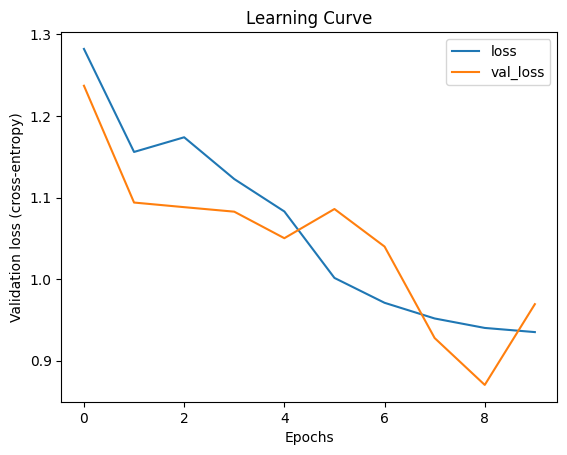

In [8]:
plot_learning_curve(history)

# Plot

## Plot a few examples from test set

1/1 [==============================] - 0s 153ms/step


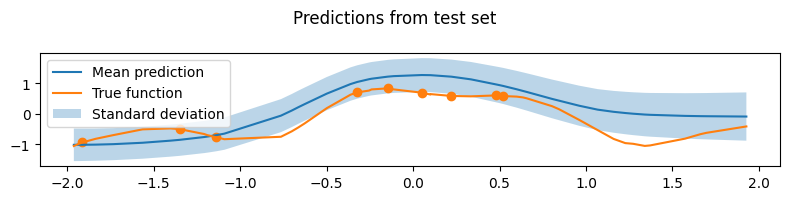

In [9]:
fig = plot_preds_from_ds_test(model, ds_test=data_generator.test_ds, num_samples=1)

1/1 [==============================] - 0s 176ms/step


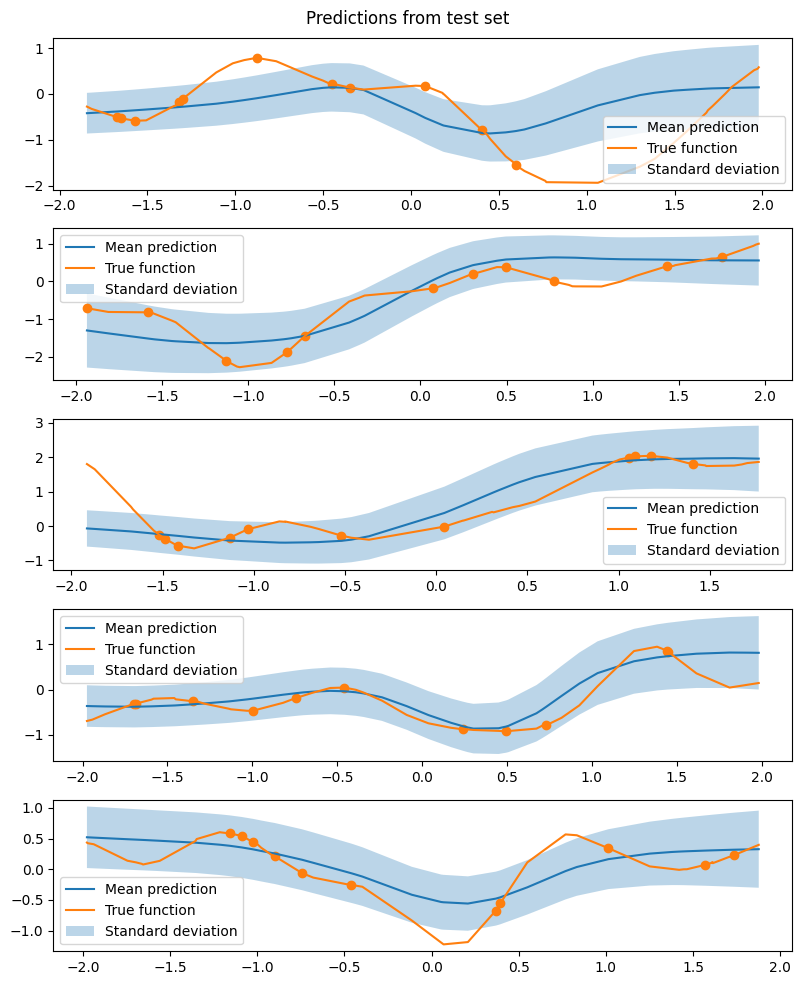

In [10]:
fig = plot_preds_from_ds_test(model, ds_test=data_generator.test_ds, num_samples=5)

## Plot for different numbers of context points

1/1 [==============================] - 0s 323ms/step


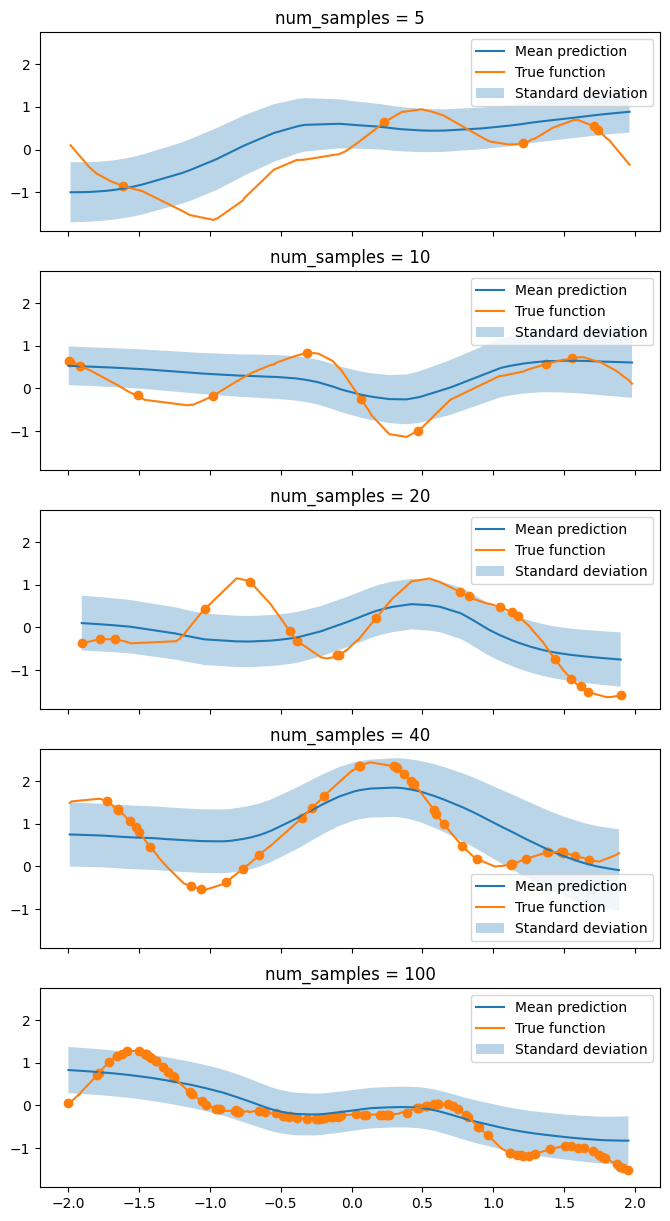

In [13]:
plot_from_arbitrary_gp_wrt_context_points(model,
                                          kernel_length_scale=KERNEL_LENGTH_SCALE,
                                          list_num_context=list_num_context)

## Plot for different numbers of context points against the true GP

In [14]:
from pathlib import Path
import tensorflow as tf
from neural_process_model_latent import NeuralProcessLatent


def load_lnp_model(model_path: str) -> tf.keras.Model:
    assert Path(model_path).parent.is_dir()

    z_output_sizes = [500, 500, 500, 500]
    enc_output_sizes = [500, 500, 500, 1000]
    dec_output_sizes = [500, 500, 500, 2]

    model = NeuralProcessLatent(z_output_sizes=z_output_sizes,
                                enc_output_sizes=enc_output_sizes,
                                dec_output_sizes=dec_output_sizes)

    model.load_weights(model_path)

    return model

In [15]:
# Load the pre-trained LNP model:
model_path = "checkpoints/LNP_model_regression_context_10_uniform_sampling_True/cp-0121.ckpt"
lnp_model = load_lnp_model(model_path)

1/1 [==============================] - 0s 38ms/step


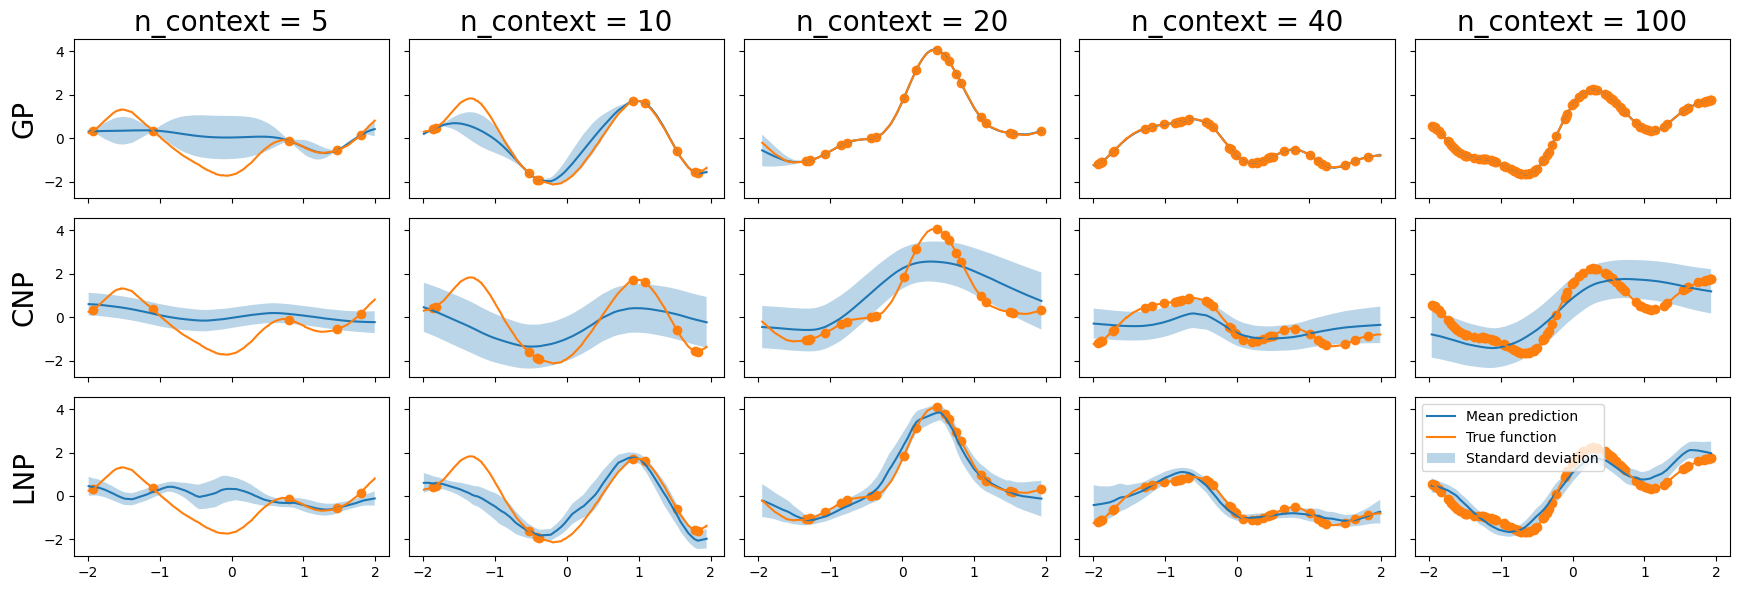

In [17]:
plot_gp_vs_cnp_vs_lnp(model,
                      lnp_model,
                      kernel_length_scale=KERNEL_LENGTH_SCALE,
                      list_num_context=list_num_context)